###### Multi-region analysis 

In this notebook we analyse the ability of a model trained on a region A to infer the subgrid forcing to achieve the same task on a different region, say region B. 

In [1]:
import mlflow
import xarray as xr
import matplotlib.pyplot as plt
from analysis.utils import select_run

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import MutableMapping
/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable, Mapping
/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Siz

In [2]:
plt.rcParams["figure.figsize"] = (20, 15)

In [3]:
def plot_dataset(dataset : xr.Dataset, plot_type = None, *args, **kargs):
    """Calls the plot function of each variable in the dataset"""
    plt.figure(figsize = (20, 5 * int(len(dataset) / 2)))
    kargs_ = [dict() for i in range(len(dataset))]
    def process_list_of_args(name: str):
        if name in kargs:
            if isinstance(kargs[name], list):
                for i, arg_value in enumerate(kargs[name]):
                    kargs_[i][name] = arg_value
            else:
                for i in range(len(dataset)):
                    kargs_[i][name] = kargs[name]
            kargs.pop(name)
    process_list_of_args('vmin')
    process_list_of_args('vmax')
    for i, variable in enumerate(dataset):
        plt.subplot(int(len(dataset) / 2), 2, i + 1)
        if plot_type is None:
            try:
                # By default we set the cmap to coolwarm
                kargs.setdefault('cmap', 'coolwarm')
                dataset[variable].plot(*args, **kargs_[i], **kargs)
            except AttributeError as e:
                kargs.pop('cmap', None)
                dataset[variable].plot(*args, **kargs)
        else:
            plt_func = getattr(dataset[variable].plot, plot_type)
            plt_func(*args, **kargs)
import matplotlib.animation as animation

def dataset_to_movie(dataset : xr.Dataset, interval : int = 50,
                    *args, **kargs):
    """Generates animations for all the variables in the dataset"""
    fig = plt.figure(figsize = (20, 5 * int(len(dataset) / 2)))
    axes = list()
    ims = list()
    for i, variable in enumerate(dataset.keys()):
        axes.append(fig.add_subplot(int(len(dataset) / 2), 2, i + 1))
    for i, t in enumerate(dataset['time']):
        im = list()
        for axis, variable in zip(axes, dataset.keys()):
            plt.sca(axis)
            img = dataset[variable].isel(time=i).plot(vmin=-2, vmax=2,
                                                      cmap='coolwarm')
            cb = img.colorbar
            cb.remove()
            im.append(img)
        ims.append(im)
    ani = animation.ArtistAnimation(fig, ims, 
                                    interval=interval, blit=True,
                                    repeat_delay=1000)
    return ani

In [4]:
client = mlflow.tracking.MlflowClient()

In [5]:
import pandas as pd
def select_run(limit=1000, sort_by=None, cols=None, merge=None, *args, **kargs):
    """Allows to select a run from the tracking store interactively"""
    mlflow_runs = mlflow.search_runs(*args, **kargs)
    if cols is None:
        cols = list()
    cols = ['run_id', 'experiment_id' ] + cols
    mlflow_runs = mlflow_runs.iloc[:limit]
    # Remove possible duplicate columns
    new_cols = list()
    for e in cols:
        if e not in new_cols:
            new_cols.append(e)
    cols = new_cols
    print(len(mlflow_runs))
    if merge is not None:
        cols[cols.index('run_id')] = 'run_id_x'
        cols[cols.index('experiment_id')] = 'experiment_id_x'
        for name, key_left, key_right in merge:
            experiment = mlflow.get_experiment_by_name(name)
            df2 = mlflow.search_runs(experiment_ids=experiment.experiment_id)
            mlflow_runs = pd.merge(mlflow_runs, df2, left_on=key_left,
                                   right_on=key_right)
    print(len(mlflow_runs))
    if len(mlflow_runs) == 0:
        raise Exception('No data found. Check that you correctly set \
                        the store')
    if sort_by is not None:
        mlflow_runs = mlflow_runs.sort_values(by=sort_by, ascending=False)
        cols.append(sort_by)
    print(mlflow_runs[cols])
    id_ = int(input('Run id?'))
    if id_ < 0:
        sys.exit()
    return mlflow_runs.loc[id_, :]

In [6]:
cols = ['start_time_x','params.model_cls_name', 'metrics.test loss', 'params.lat_min', 
       'params.lat_max', 'params.long_min', 'params.long_max', 'params.n_epochs_x', 'params.model_run_id']
run = select_run(sort_by='start_time_x', cols=cols, merge=[('meeting22july', 'params.model_run_id', 'run_id'),
                                  ('forcingdatav3', 'params.data_run_id', 'run_id')], experiment_ids = ['12',])

Traceback (most recent call last):
  File "/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 585, in _list_run_infos
    run_info = self._get_run_info_from_dir(r_dir)
  File "/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 423, in _get_run_info_from_dir
    meta = read_yaml(run_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 160, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/scratch/ag7531/mlruns/12/a4da4cad3ecc4412af086e7bad8eb8bd/meta.yaml' does not exist.


24
3
                           run_id_x experiment_id_x  \
0  235204ea3a15413f8113e0271dbba24a              12   
1  7606981f52144e0c8472e199785d60ac              12   
2  5a14d68dbd6746638258558cfbb4ffa9              12   

                      start_time_x params.model_cls_name  metrics.test loss  \
0 2020-07-24 14:06:48.826000+00:00              FullyCNN          -1.760762   
1 2020-07-24 10:01:32.841000+00:00              FullyCNN          -1.760762   
2 2020-07-22 08:59:03.065000+00:00              FullyCNN          -1.760762   

  params.lat_min params.lat_max params.long_min params.long_max  \
0            -60              0              60             110   
1            -60              0              60             110   
2             20             35             -30             -18   

  params.n_epochs_x               params.model_run_id  \
0                 0  2370107146564198b9f7351036632770   
1                 0  2370107146564198b9f7351036632770   
2                

In [7]:
for k,v in run.items():
    print(f'{k}: {v}')

run_id_x: 5a14d68dbd6746638258558cfbb4ffa9
experiment_id_x: 12
status_x: FINISHED
artifact_uri_x: /scratch/ag7531/mlruns/12/5a14d68dbd6746638258558cfbb4ffa9/artifacts
start_time_x: 2020-07-22 08:59:03.065000+00:00
end_time_x: 2020-07-22 09:09:30.380000+00:00
metrics.mse_x: 0.20767951424627448
metrics.Inf Norm_x: 2.750422538611019e-07
metrics.validation loss: 0.0
params.model_run_id: 2370107146564198b9f7351036632770
params.data_run_id: 08db5f2f1c8b45c1879fa235f6eaad3a
params.n_epochs_x: 0
tags.mlflow.user_x: ag7531
tags.mlflow.source.type_x: LOCAL
tags.mlflow.source.name_x: /home/ag7531/code/subgrid/testing/main.py
tags.mlflow.source.git.commit_x: fbed3c214941cd805e93a485154228434aaa19d6
run_id_y: 2370107146564198b9f7351036632770
experiment_id_y: 17
status_y: FINISHED
artifact_uri_y: /scratch/ag7531/mlruns/17/2370107146564198b9f7351036632770/artifacts
start_time_y: 2020-07-22 08:04:01.181000+00:00
end_time_y: 2020-07-22 08:57:35.031000+00:00
metrics.test loss: -1.7607615370455085
metric

In [8]:
data_run_id = run['params.data_run_id']
data_run = client.get_run(data_run_id)

In [9]:
import numpy as np
data_file = client.download_artifacts(data_run_id, 'forcing')
data = xr.open_zarr(data_file)
data['time_index'] = xr.DataArray(np.arange(len(data.coords['time'])),
                                       dims = ('time',),
                                       coords = {'time' : data['time']})
data = data.swap_dims({'time' : 'time_index'})

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.Iterator):
/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


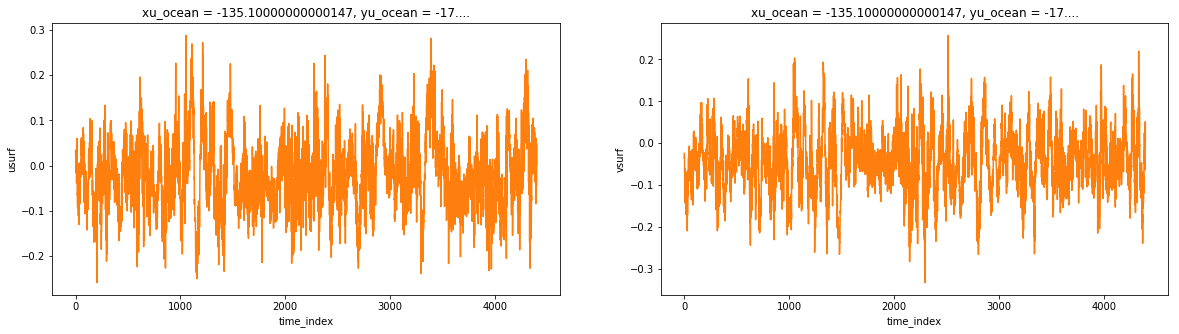

In [10]:
from random import randint
plot_dataset(data[['usurf', 'vsurf']].isel(xu_ocean=randint(0, len(data['xu_ocean'])),
                                           yu_ocean=randint(0, len(data['yu_ocean']))))

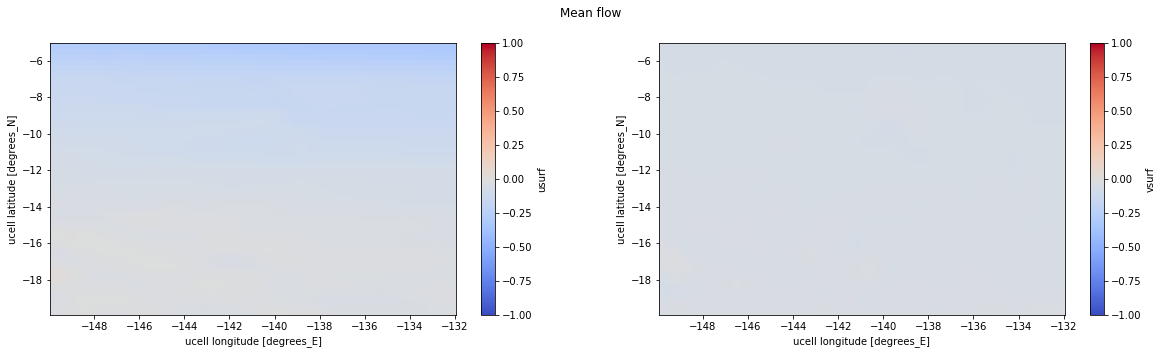

In [11]:
plot_dataset(data[['usurf', 'vsurf']].mean(dim='time_index'), cmap='coolwarm', vmin=-1, vmax=1)
_ = plt.suptitle('Mean flow')

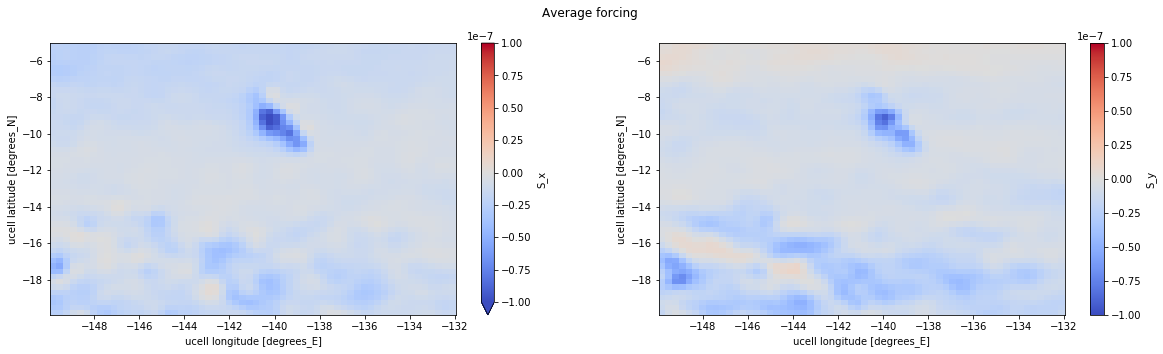

In [12]:
plot_dataset(data[['S_x', 'S_y']].mean(dim='time_index'), cmap='coolwarm', vmin=-1e-7, vmax=1e-7)
_ = plt.suptitle('Average forcing')

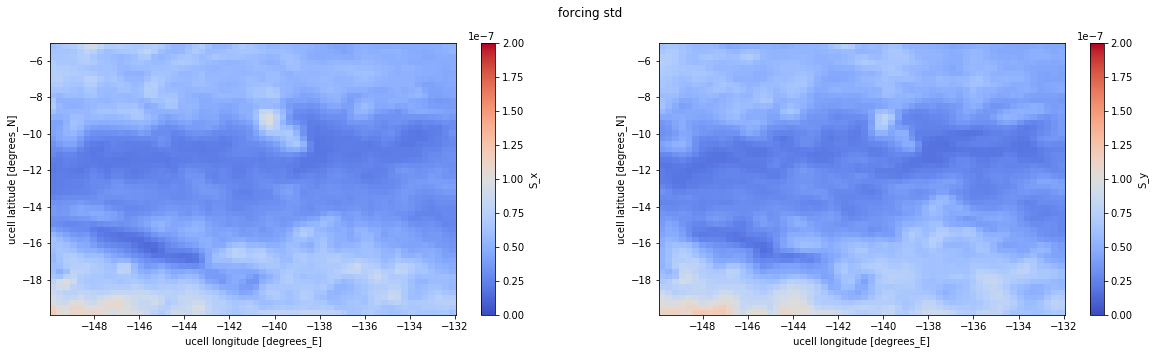

In [13]:
plot_dataset(data[['S_x', 'S_y']].std(dim='time_index'), cmap='coolwarm', vmin=0, vmax=2e-7)
_ = plt.suptitle('forcing std')

In [14]:
data[['usurf', 'vsurf', 'S_x', 'S_y']].std().compute()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    usurf    float64 0.1183
    vsurf    float64 0.07184
    S_x      float64 5.169e-08
    S_y      float64 5.19e-08

In [38]:
eddy_data = data[['usurf', 'vsurf']] - data[['usurf', 'vsurf']].mean(dim='time_index')
eddy_data['usurf'].attrs['units'] = r'$m \ s^{-1}$'
eddy_data['vsurf'].attrs['units'] = r'$m \ s^{-1}$'
eddy_data['usurf'].attrs['long_name'] = 'eddy usurf'
eddy_data['vsurf'].attrs['long_name'] = 'eddy vsurf'

<Figure size 1440x720 with 0 Axes>

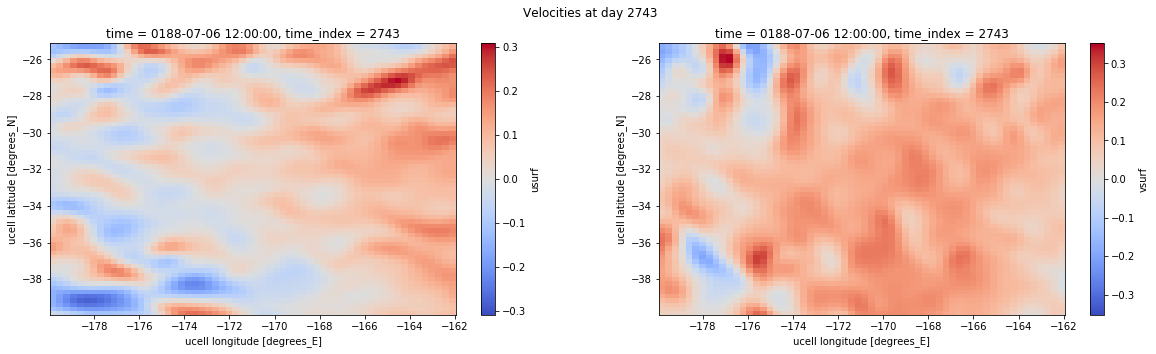

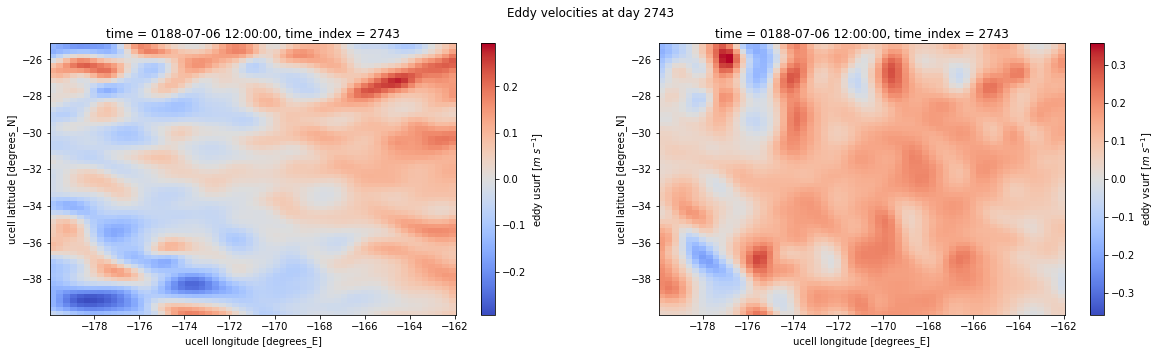

In [39]:
random_time = randint(0, len(eddy_data['time_index']))
fig = plt.figure(figsize=(20, 10))
plot_dataset(data[['usurf', 'vsurf']].isel(time_index=random_time))
_ = plt.suptitle('Velocities at day {}'.format(random_time))
plot_dataset(eddy_data[['usurf', 'vsurf']].isel(time_index=random_time))
_ = plt.suptitle('Eddy velocities at day {}'.format(random_time))

In [18]:
data['kinetic energy'] = 1/2*1e4*(data['usurf']**2 + data['vsurf']**2)
data['kinetic energy'].attrs['units'] = r'$(cm/s)^2$'
eddy_data['eddy kinetic energy'] = 1/2*1e4*(eddy_data['usurf']**2 + eddy_data['vsurf']**2)
eddy_data['eddy kinetic energy'].attrs['units'] = r'$(cm/s)^2$'

In [19]:
mean_kinetic_energy = data['kinetic energy'].mean(dim='time_index')
mean_kinetic_energy.attrs['units'] = r'$(cm/s)^2$'
mean_eddy_kinetic_energy = eddy_data['eddy kinetic energy'].mean(dim='time_index')
mean_eddy_kinetic_energy.attrs['units'] = r'$(cm/s)^2$'

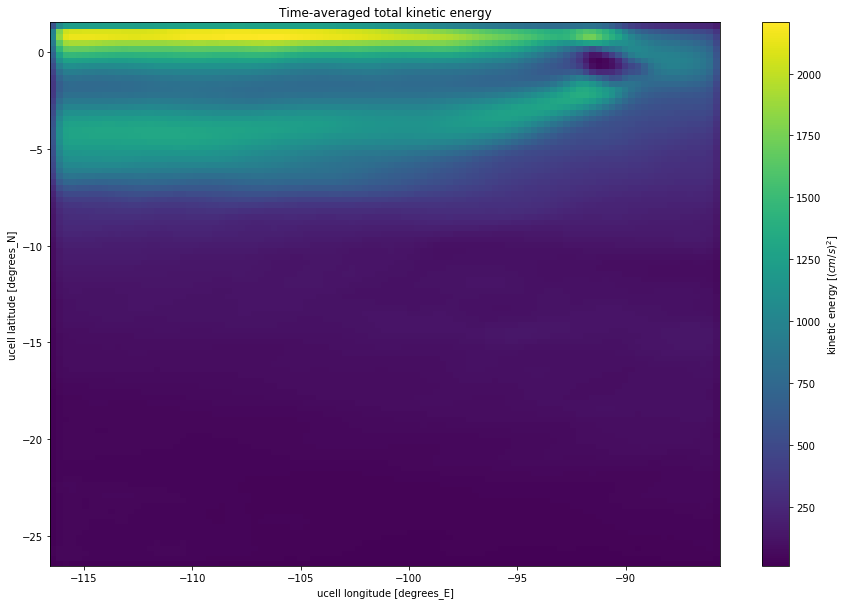

In [20]:
mean_kinetic_energy.plot()
_ = plt.title('Time-averaged total kinetic energy')

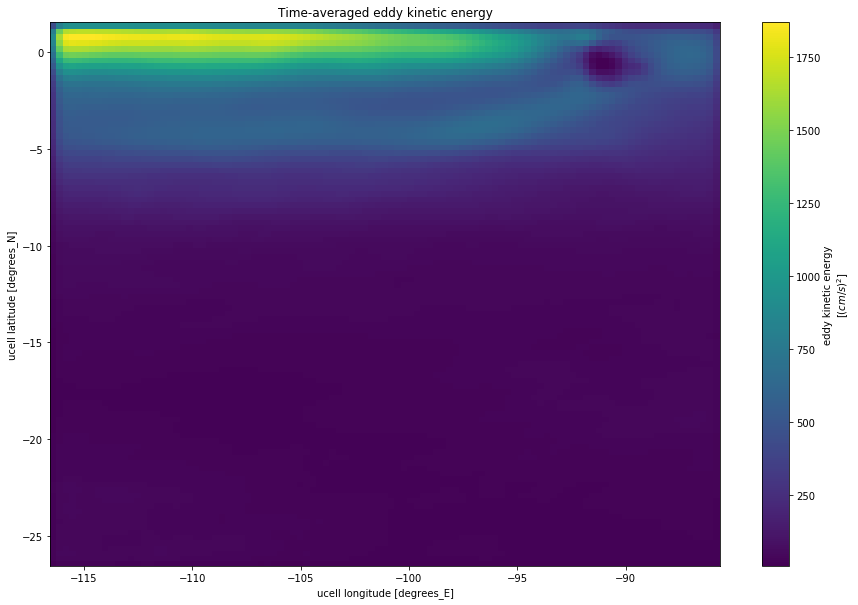

In [21]:
mean_eddy_kinetic_energy.plot()
_ = plt.title('Time-averaged eddy kinetic energy')

In [9]:
from analysis.base import get_test_datasets
test_datasets = get_test_datasets(run['run_id_x'])

. test_output_0 .
loading
. test_output_1 .
loading
. test_output_2 .
loading
. test_output_3 .
loading
. test_output_4 .
loading
. test_output_5 .
loading
. test_output_6 .
loading
. test_output_7 .
loading
. test_output_8 .
loading
. test_output_9 .
loading


In [10]:
import numpy as np
lat = np.arange(-80, 80, 1)
lon = np.arange(-279.9, 80.1, 1)
interp_dss = []
for ds in test_datasets:
    ds = ds.ds
    ds = ds.chunk(dict(time=1, latitude=None, longitude=None))
    interp_dss.append(ds.interp(dict(latitude=lat, longitude=lon),
                                method='nearest', kwargs=dict(bounds_error=False, fill_value=0.)))
    interp_dss[-1] = interp_dss[-1].chunk(dict(latitude=None, longitude=None))

In [14]:
final_ds = sum(interp_dss)

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


([<matplotlib.axis.YTick at 0x2b53d6689590>,
 <a list of 6 Text yticklabel objects>)

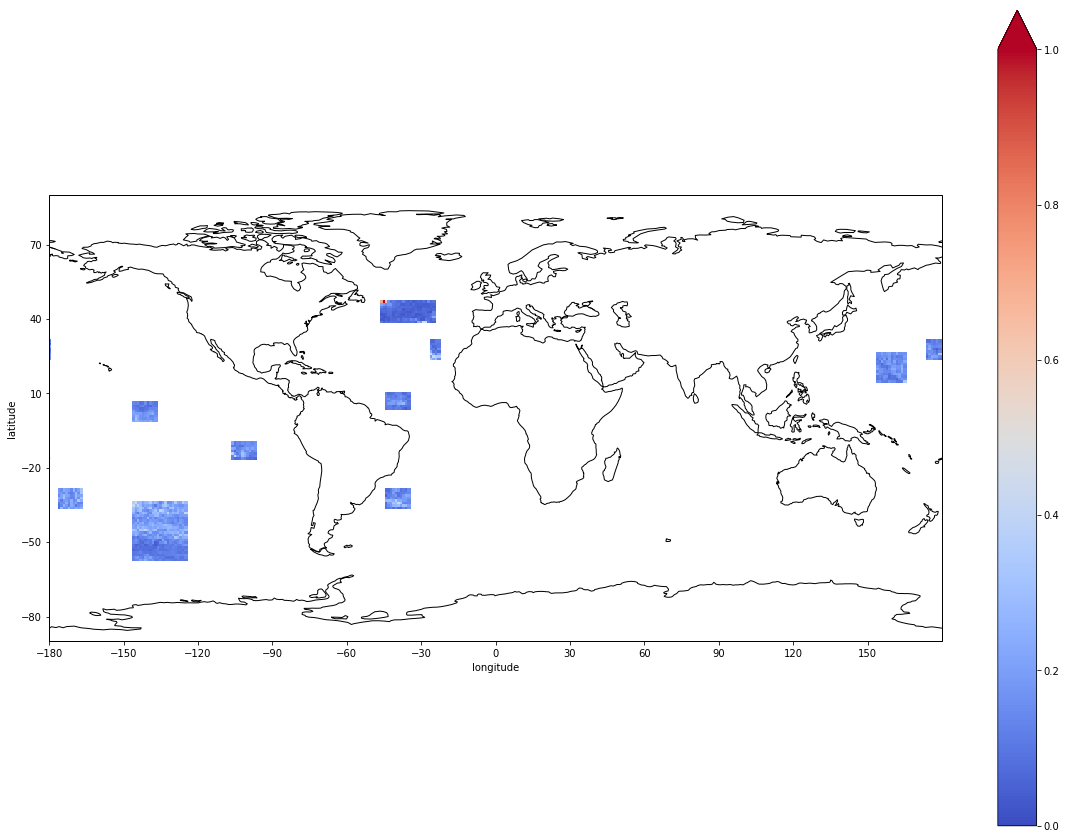

In [13]:
import cartopy.crs as ccrs
final_ds = final_ds.where(abs(final_ds) > 0)
ax = plt.axes(projection=ccrs.PlateCarree())
squared_error = ((final_ds['S_xpred'] - final_ds['S_x']))**2
(squared_error.mean(dim='time') / (final_ds['S_x']**2).mean(dim='time')).plot(ax=ax, transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap='coolwarm')
ax.set_global()
ax.coastlines()
plt.xticks(final_ds.longitude[::30] + 99.9)
plt.yticks(final_ds.latitude[::30])

In [12]:
test_datasets[0]

In [13]:
id = 0
error = (test_datasets[id]['S_xpred'] - test_datasets[id]['S_x']) 
error0 = test_datasets[id]['S_x']

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.Iterator):


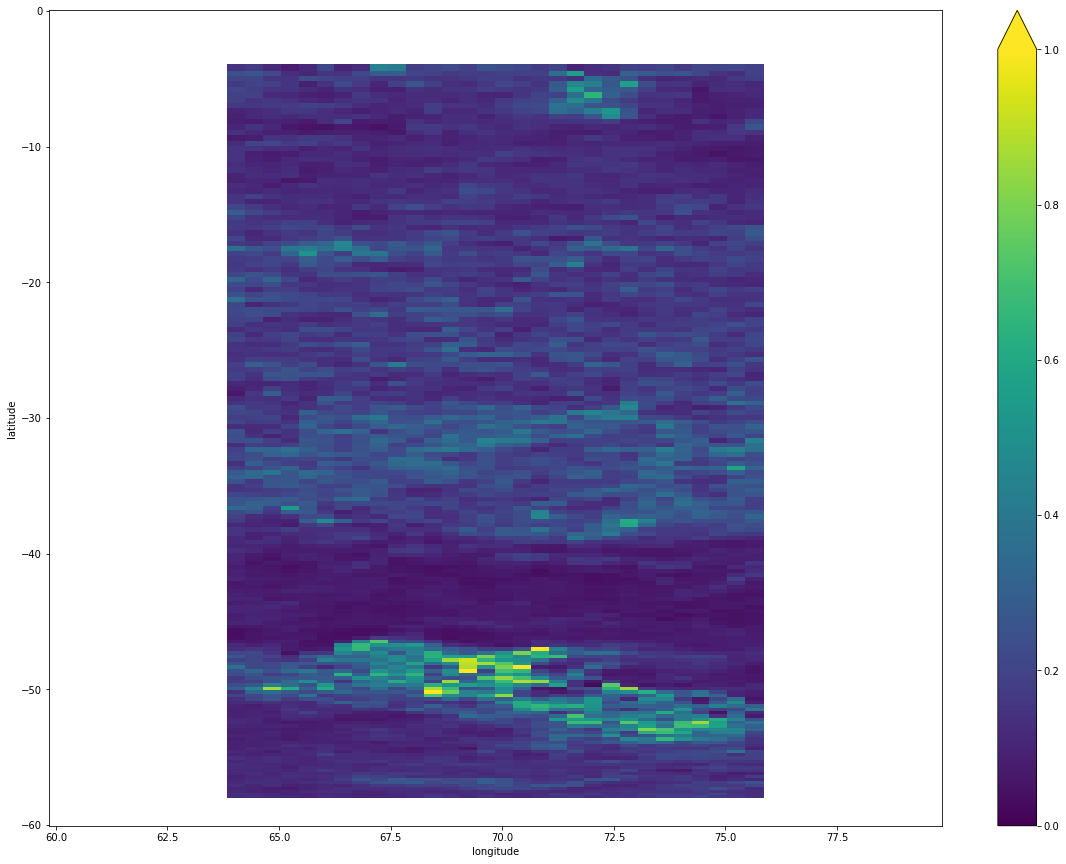

In [14]:
((error**2).mean(dim='time') / (error0**2).mean(dim='time')).plot(vmin=0., vmax=1)

In [14]:
import numpy as np
model_output = test_datasets[id]
model_output['S_xscale'] = 1/(model_output['S_xscale'])
model_output['S_yscale'] = 1/(model_output['S_yscale'])
model_output['err_S_x'] = (model_output['S_x'] - model_output['S_xpred'])**2
model_output['err_S_y'] = (model_output['S_y'] - model_output['S_ypred'])**2

In [15]:
model_output['time_index'] = xr.DataArray(np.arange(len(model_output.coords['time'])),
                                       dims = ('time',),
                                       coords = {'time' : model_output['time']})
model_output = model_output.swap_dims({'time' : 'time_index'})

Random time index:  1102


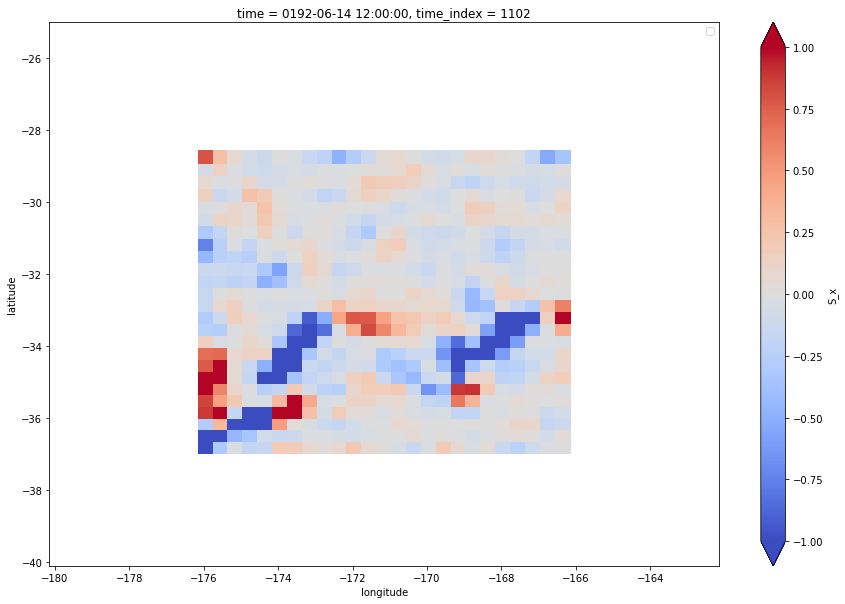

In [16]:
# Random snapshot of the forcing for Laure
from random import randint
n_times = len(model_output['time'])
random_time = randint(0, n_times)
print('Random time index: ', random_time)
(model_output['S_x'].isel(time_index=random_time)).plot(vmin=-1., vmax=1., cmap='coolwarm')
plt.legend(r'S_x ($m^4s^{-3})')

377


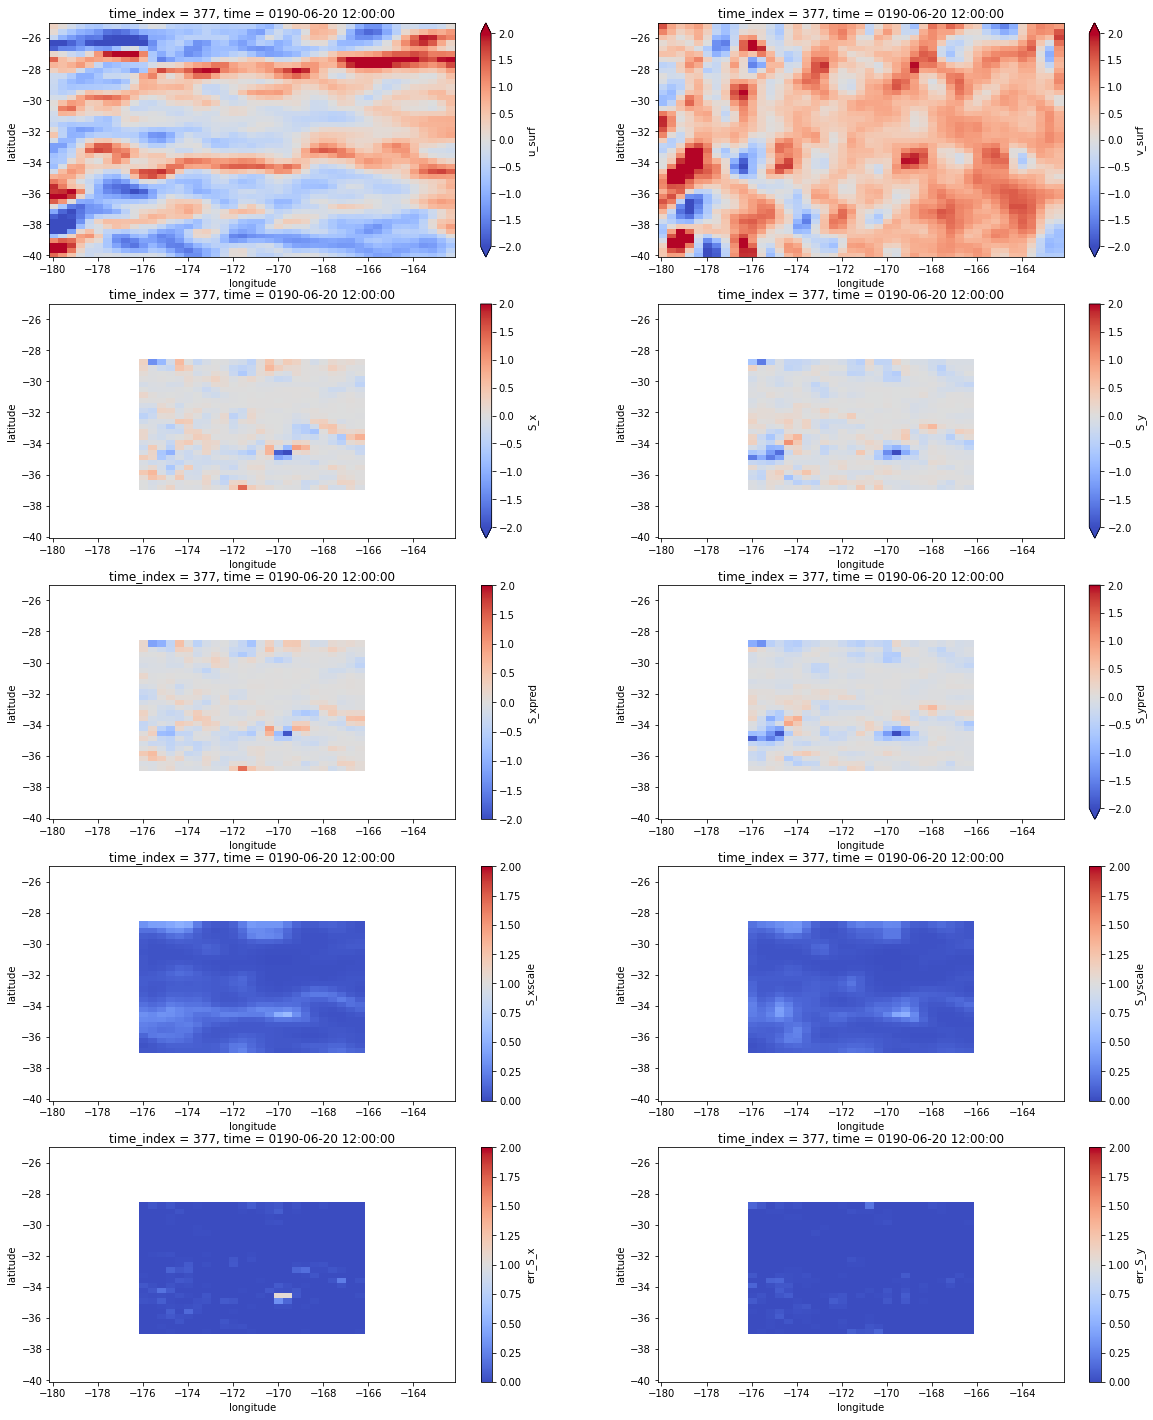

In [18]:
from random import randint
random_time = randint(0, n_times)
print(random_time)
plot_dataset(model_output.isel(time_index=random_time)[['u_surf', 'v_surf', 'S_x', 'S_y', 'S_xpred', 'S_ypred',
                                                          'S_xscale', 'S_yscale', 'err_S_x', 'err_S_y']],
            vmin = [-2]*6 + [0., 0., 0., 0.], vmax = [2]*6 + [2, 2,2,2])

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


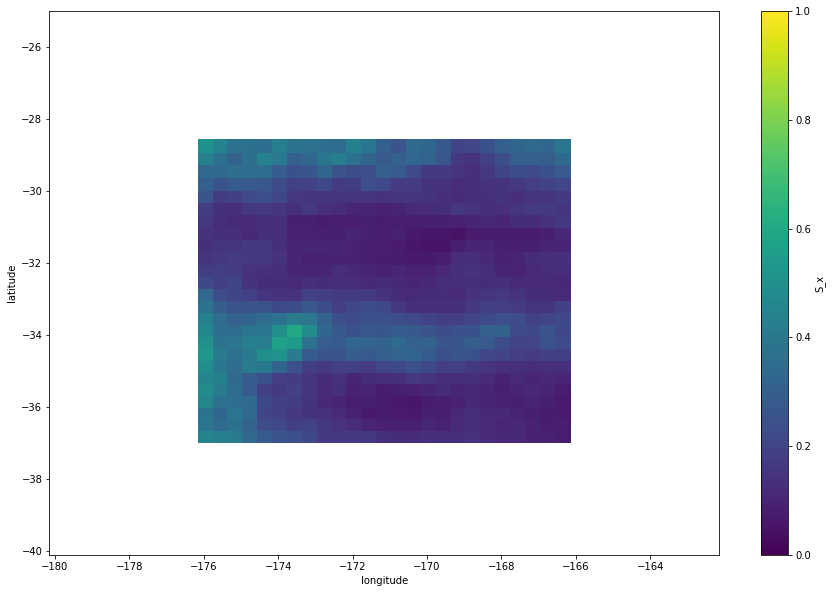

In [19]:
(abs(model_output['S_x'])).mean(dim='time_index').plot(vmin=0, vmax=1)

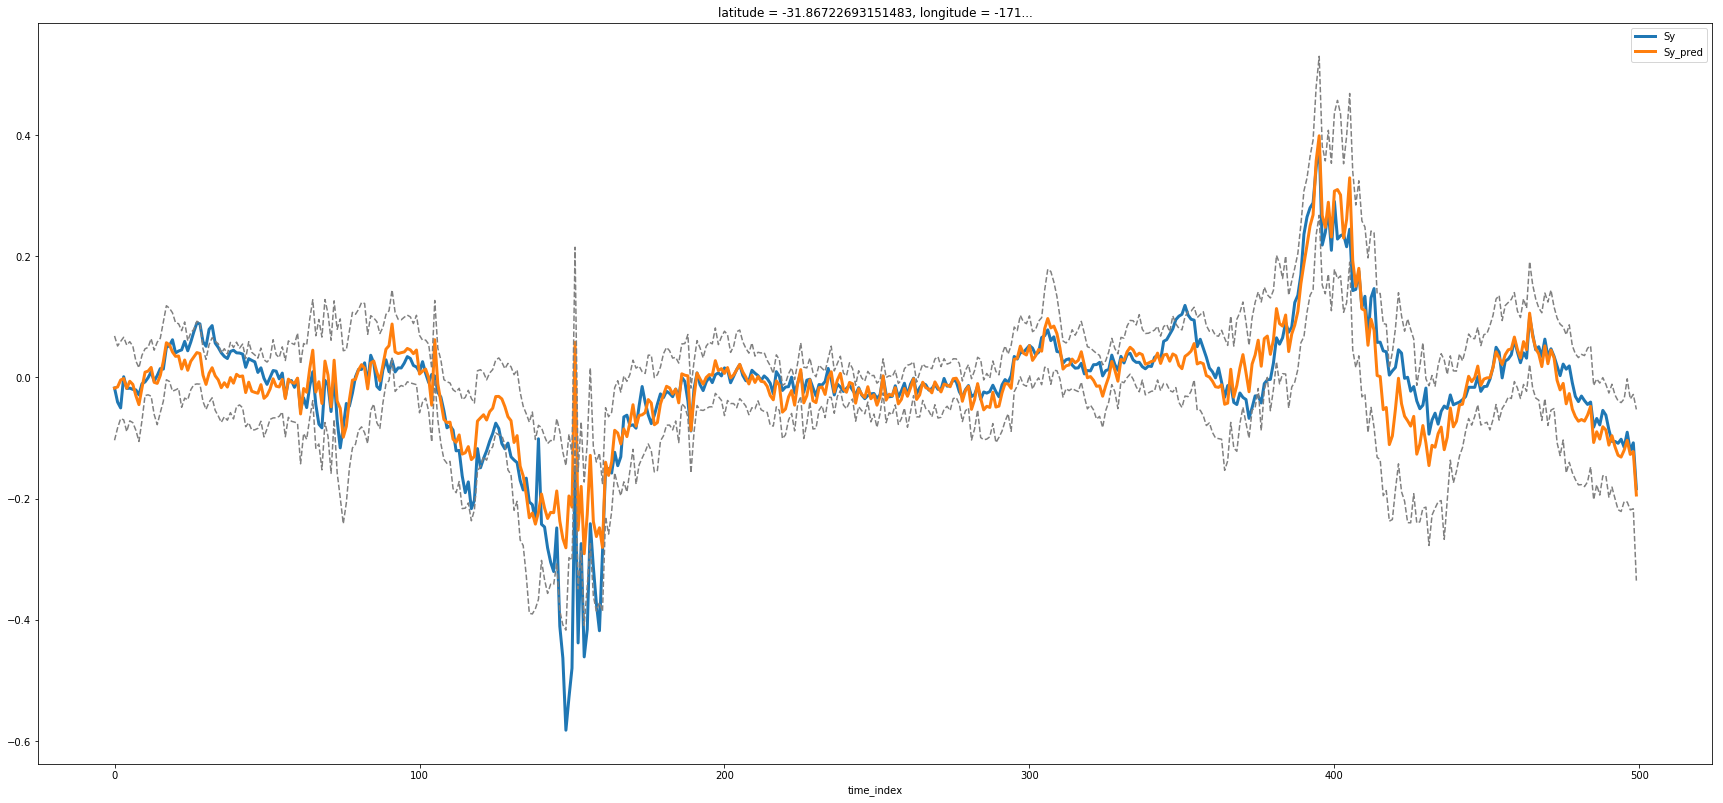

In [20]:
fig = plt.figure(figsize=(30, 30))
long = -172
lat = -32
plt.subplot(2, 1, 1)
time = slice(0, 500)
model_output['S_y'].isel(time_index=time).sel(longitude=long, latitude=lat, method='nearest').plot(linewidth=3)
model_output['S_ypred'].isel(time_index=time).sel(longitude=long, latitude=lat, method='nearest').plot(linewidth=3)
uB = model_output['S_ypred'] + 1.96 * model_output['S_yscale']
lB = model_output['S_ypred'] - 1.96 * model_output['S_yscale']
uB.isel(time_index=time).sel(longitude=long, latitude=lat, method='nearest').plot(linestyle='--',color='gray')
lB.isel(time_index=time).sel(longitude=long, latitude=lat, method='nearest').plot(linestyle='--',color='gray')
plt.legend(('Sy', 'Sy_pred'))

In [21]:
correlations = (model_output['S_y'] * model_output['S_ypred']).mean(dim='time_index') / np.sqrt((model_output['S_y']**2).mean(dim='time_index') * (model_output['S_ypred']**2).mean(dim='time_index'))

/home/ag7531/miniconda3/envs/mlflow-2428cb47d93b4486f90b5f8bb1835e697d4a2328/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


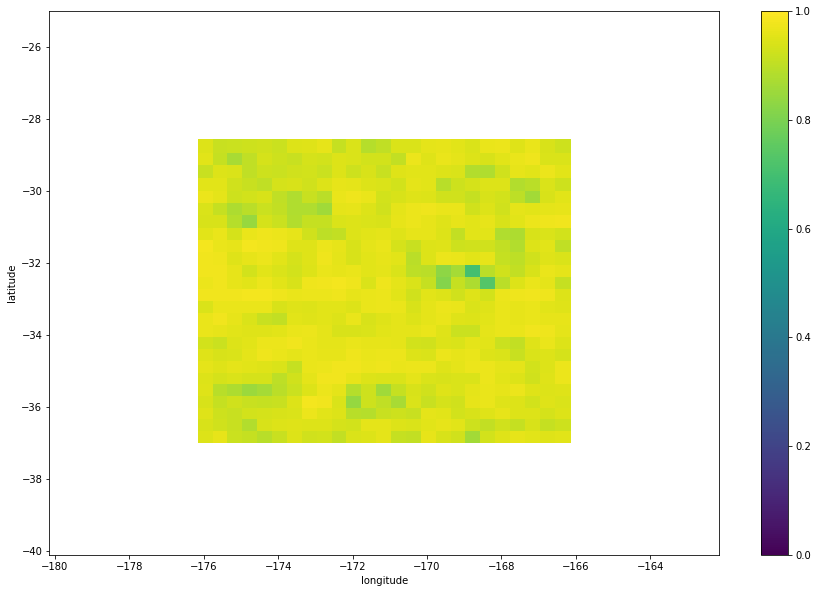

In [24]:
correlations.plot(vmin=0., vmax=1)